#### TASK_3

The goal of this challenge is the classification of 9 regularly misidentified cell lines based on microscopy images. The classes to distinguish are PC-3, U-251 MG, HeLa, A549, U-2 OS, MCF7, HEK 293, CACO-2 and RT4.
Each sample contains at least one cell and consists of 3 seperate images showing different parts (nucleus, microtubules, endoplasmic reticulum) of the same cell. 

Hint: Combining the separate images to one 3-channel-image allows to treat a sample like a regular RGB image.

In [1]:
# import necessary libraries 
import os
import tarfile
import torch
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
from PIL import Image
import csv 
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.layers import UpSampling2D

#### training data load and preparation 

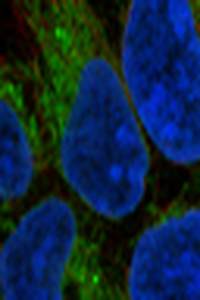

In [2]:
path = './my_folder/images_train'

train_dict = {}
for root, dirs, files in os.walk(path):
    for file in files:
        train_dict[file] = np.array(Image.open(f'{path}\\{file}'))
        
train_list = list(train_dict.values())


################################################################

image_np_list = []

for blue, red, yellow in zip(*[iter(train_list)]*3):
    
    rbg_temp = np.dstack((red,yellow,blue))
    rbm_temp = rbg_temp/255.0
    image_np_list.append(rbg_temp)

    rgb_image_list = []

####################################################################
    
    
rgb_image_list = []

for i in range (0,len(image_np_list)):
    
    pil_img = Image.fromarray(np.uint8(image_np_list[i])).convert('RGB')
    
    rgb_image_list.append(pil_img)
    
x_train_np = np.array(image_np_list)

rgb_image_list[99].resize((200,300), Image.ANTIALIAS)

#### train_labels (classes) loading and convert to one-hot encoding vector

In [84]:
import csv 

with open('y_train.csv', newline='') as f:
    y_train = csv.reader(f)
    img_labels = list(y_train)
    
    
y_train_pd = pd.read_csv('y_train.csv', index_col=0)

y_train_pd['numerical_labels'] = pd.Categorical(y_train_pd['cell_line']).codes

y_labels = np.array(y_train_pd['numerical_labels'])

y_train_one_hot = to_categorical(y_labels)



#### test data load and preparation 

In [5]:
path = './image_test/images_test'

test_dict = {}
for root, dirs, files in os.walk(path):
    for file in files:
        test_dict[file] = np.array(Image.open(f'{path}\\{file}'))

test_list = list(test_dict.values())


#################################################################

image_test_list = []


for blue, red, yellow in zip(*[iter(test_list)]*3):
    
    rbg_test = np.dstack((red,yellow,blue))
    rbg_test = rbg_test/255.0
    image_test_list.append(rbg_test)
    
x_test_np = np.asarray(image_test_list)

##### data augmentation

In [7]:
from PIL import Image
from matplotlib import pyplot

augmentation_data_list = []
one_hot_list = []


for i in range(0,len(rgb_image_list)):
    
    temp_flip_left_right = rgb_image_list[i].transpose(Image.FLIP_LEFT_RIGHT)
    temp_flip_top_bottom = rgb_image_list[i].transpose(Image.FLIP_TOP_BOTTOM)
    temp_rotate_45 = rgb_image_list[i].rotate(45)
    temp_rotate_90 = rgb_image_list[i].rotate(90)
    
    augmentation_data_list.append(temp_flip_left_right)
    augmentation_data_list.append(temp_flip_top_bottom)
    augmentation_data_list.append(temp_rotate_45)
    augmentation_data_list.append(temp_rotate_90)
    
    for j in range(4):
        
        one_hot_list.append(y_train_one_hot[i])

        
augmented_image_np_list = []

for i in range(0,len(augmentation_data_list)):
    
    temp_img = augmentation_data_list[i]
    img_array = np.array(temp_img)/225.0
    
    augmented_image_np_list.append(img_array)

    

augmented_image_np = np.array(augmented_image_np_list)

total_train_x = np.vstack((x_train_np,augmented_image_np))
total_one_hot_y = np.vstack((y_train_one_hot, np.array(one_hot_list)))

train_x, val_x, train_y, val_y = train_test_split(total_train_x, total_one_hot_y, test_size = 0.25)


#### Build a CNN model for training 

In [18]:
model=Sequential()

model.add(Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.10))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.50))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
          
model.add(Dense(9,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [87]:
#we have 9 categories so loss function is categorical_crossentropy
#metrics accuracy


model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist=model.fit(train_x,train_y,epochs=140,batch_size=64,validation_split=0.2)


AttributeError: 'NoneType' object has no attribute 'compile'

In [22]:
# `save('model_cnn_140_epochs.h5')` creates a h5 file `model_cnn_140_epochs.h5`.
model.save("model_cnn_140_epochs.h5")


In [23]:

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("model_cnn_140_epochs.h5")

In [24]:
#model evaluation
test_loss,test_acc=model.evaluate(val_x,val_y)
test_loss,test_acc

377/377 [==============================] - 15s 41ms/step - loss: 0.3581 - accuracy: 0.8940


(0.35808178782463074, 0.8940199613571167)

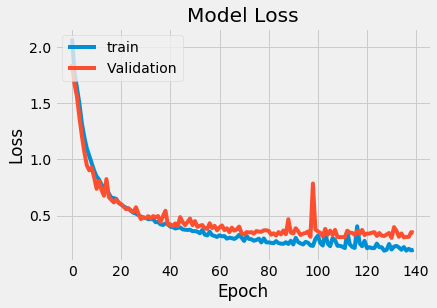

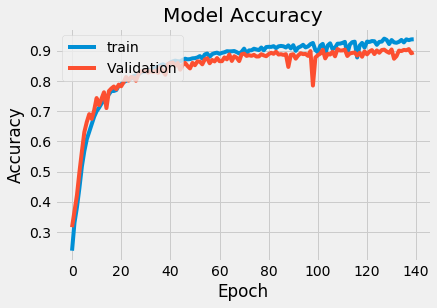

In [25]:
#train and validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','Validation'],loc='upper left')
plt.show()

#train and validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','Validation'],loc='upper left')
plt.show()

#### Make a prediction of the test dataset

In [28]:
y_pred=model.predict_classes(x_test_np)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([8, 1, 1, ..., 6, 3, 4], dtype=int64)

In [86]:
## convert the predicted classes into the given list of "string" classes 
## and then save and export to csv file format.

class_name_list = []

for i in range(0,len(y_pred)):
    
    classes = ["A549", "CACO-2", "HEK 293", "HeLa", "MCF7", "PC-3", "RT4", "U-2 OS", "U-251 MG"]
    
    for idx in range(9):
        
        if y_pred[i] == idx:
            
            class_name_list.append(classes[idx])
   

       
class_name_pd = pd.DataFrame(class_name_list)
df = pd.DataFrame()
df.insert(0,'file_id',range(9633,9633+len(x_test_np)))
y_pred_pd = pd.DataFrame(y_pred)
test_classification_labels = pd.concat([df, class_name_pd], axis=1)
test_classification_labels.columns = ['file_id','cell_line']
print(test_classification_labels)      
        
    
test_classification_labels.to_csv (r'.\task4_cell_line.csv', index = False, header=True)



      file_id cell_line
0        9633  U-251 MG
1        9634    CACO-2
2        9635    CACO-2
3        9636      MCF7
4        9637    U-2 OS
...       ...       ...
6864    16497   HEK 293
6865    16498   HEK 293
6866    16499       RT4
6867    16500      HeLa
6868    16501      MCF7

[6869 rows x 2 columns]
